In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 16.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
openc

In [ ]:
import pandas as pd
import numpy as np
import re
import os
import time
import pickle

# For Keras model building
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout # Import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

# For data splitting and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
file_path = '/content/drive/MyDrive/Depression detection dataset/BSMDD_main.xlsx'
df = pd.read_excel(file_path)

# Drop any rows where the text is missing and reset index
df.dropna(subset=['text_banglish'], inplace=True)
df.reset_index(drop=True, inplace=True)

print("Libraries imported, Drive mounted, and dataset loaded successfully.")
df.info()

Mounted at /content/drive
Libraries imported, Drive mounted, and dataset loaded successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21910 entries, 0 to 21909
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_bengali   21910 non-null  object
 1   text_banglish  21910 non-null  object
 2   label          21910 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 513.6+ KB


In [ ]:
# --- 1. Define the text preprocessing function ---
def preprocess_text(text):
    text = str(text).lower()  # Convert to lowercase and ensure it's a string
    text = re.sub(r'[^a-z\s]', '', text) # Remove punctuation, numbers, etc.
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    return text

# --- 2. Apply the function to create a 'cleaned_text' column ---
df['cleaned_text'] = df['text_banglish'].apply(preprocess_text)

# --- 3. Safeguard: Remove any rows that became empty after cleaning ---
original_rows = len(df)
df = df[df['cleaned_text'] != ''].reset_index(drop=True)
if original_rows > len(df):
    print(f"Removed {original_rows - len(df)} rows that were empty after preprocessing.")

# --- 4. Display the result to verify ---
print("DataFrame after preprocessing:")
print(df[['text_banglish', 'cleaned_text', 'label']].head())

Removed 2 rows that were empty after preprocessing.
DataFrame after preprocessing:
                                       text_banglish  \
0  manasika sharirikabhabe asustha klanta puro ji...   
1  daya sathe thakuna atyanta dirgha apanake pada...   
2  janatama sathe bhula loka kharapa jibana katiy...   
3  anetibha imreji spikarera anusarana biraktikar...   
4  anetibha imreji spikarera anusarana biraktikar...   

                                        cleaned_text  label  
0  manasika sharirikabhabe asustha klanta puro ji...      1  
1  daya sathe thakuna atyanta dirgha apanake pada...      1  
2  janatama sathe bhula loka kharapa jibana katiy...      1  
3  anetibha imreji spikarera anusarana biraktikar...      1  
4  anetibha imreji spikarera anusarana biraktikar...      1  


In [ ]:
# --- 1. Download the GloVe Embeddings ---
# We'll use the 100-dimensional version trained on 6 billion tokens.
print("Downloading GloVe embeddings... (This is an 822MB file and may take several minutes)")
!wget --quiet http://nlp.stanford.edu/data/glove.6B.zip

print("\nUnzipping the file...")
!unzip -q glove.6B.zip # The -q flag makes the output less verbose


# --- 2. Parse the GloVe File and Load into a Dictionary ---
# We create a dictionary that maps words (strings) to their embedding vectors (numpy arrays).
glove_file = 'glove.6B.100d.txt'
embedding_dim = 100 # This must match the GloVe file we are using (e.g., 100d)
glove_embeddings = {}

print(f"\nLoading word vectors from '{glove_file}' into memory...")
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector

print(f"Successfully loaded {len(glove_embeddings):,} word vectors.")


Unzipping the file...

Loading word vectors from 'glove.6B.100d.txt' into memory...
Successfully loaded 400,000 word vectors.


In [ ]:
# --- 1. Use Keras Tokenizer to convert texts to integer sequences ---
texts = df['cleaned_text'].tolist()
labels = df['label'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
keras_vocab_size = len(word_index) + 1
print(f"Vocabulary size for Keras Tokenizer (our dataset): {keras_vocab_size}")


# --- 2. Pad sequences to a uniform length ---
lengths = [len(s) for s in sequences]
maxlen = int(np.percentile(lengths, 95))
print(f"Padding sequences to a max length of: {maxlen}")

X = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
y = labels


# --- 3. Create the embedding matrix from the GloVe model ---
hits = 0
misses = 0
embedding_matrix = np.zeros((keras_vocab_size, embedding_dim)) # embedding_dim is 100

for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        # Words not found in the GloVe vocabulary will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

print(f"\nShape of the embedding matrix: {embedding_matrix.shape}")
print(f"Converted {hits} words from our vocabulary ({misses} misses).")


# --- 4. Split data into training and testing sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

print(f"\nTraining data shape (X_train): {X_train.shape}")
print(f"Testing data shape (X_test): {X_test.shape}")

Vocabulary size for Keras Tokenizer (our dataset): 56827
Padding sequences to a max length of: 192

Shape of the embedding matrix: (56827, 100)
Converted 3578 words from our vocabulary (53248 misses).

Training data shape (X_train): (17526, 192)
Testing data shape (X_test): (4382, 192)


In [ ]:
# --- 1. Build the LSTM Model ---

model = Sequential()

# Embedding Layer (loaded with our GloVe-based weights)
# We freeze this layer because the embeddings are pre-trained.
model.add(Embedding(input_dim=keras_vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=True))

# LSTM Layer (This is the main change from the previous models)
model.add(LSTM(units=64))

# Dropout for regularization
model.add(Dropout(0.3))

# A standard fully-connected Dense layer
model.add(Dense(32, activation='relu'))

# Final Output Layer for binary classification
model.add(Dense(1, activation='sigmoid'))


# --- 2. Compile the Model ---
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])


# --- 3. Print Model Summary ---
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     5,682,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,682,700 (21.68 MB)

 Trainable params: 5,682,700 (21.68 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- 1. Set up Training Parameters ---
print("Starting LSTM model training...")

# Add a callback for Early Stopping to prevent overfitting.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define number of epochs and batch size
epochs = 20
batch_size = 32


# --- 2. Train the Model and Measure Time ---
# Start the timer
start_time = time.time()

# Train the model on the training data
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test), # Evaluate on test data at the end of each epoch
                    callbacks=[early_stopping])

# Stop the timer
end_time = time.time()

# Calculate and print the training time
training_time = end_time - start_time
print(f"\nTraining finished in {training_time:.2f} seconds (approx {training_time/60:.1f} minutes).")

Starting LSTM model training...
Epoch 1/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 119s 210ms/step - accuracy: 0.5021 - loss: 0.6928 - precision: 0.5070 - recall: 0.6319 - val_accuracy: 0.5023 - val_loss: 0.6900 - val_precision: 0.5013 - val_recall: 0.9964
Epoch 2/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 113s 206ms/step - accuracy: 0.5057 - loss: 0.6841 - precision: 0.5021 - recall: 0.3894 - val_accuracy: 0.5183 - val_loss: 0.6857 - val_precision: 0.8403 - val_recall: 0.0456
Epoch 3/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 141s 205ms/step - accuracy: 0.5275 - loss: 0.6681 - precision: 0.5377 - recall: 0.4394 - val_accuracy: 0.5217 - val_loss: 0.6983 - val_precision: 0.7474 - val_recall: 0.0661
Epoch 4/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 140s 202ms/step - accuracy: 0.6055 - loss: 0.6603 - precision: 0.7424 - recall: 0.3468 - val_accuracy: 0.6337 - val_loss: 0.6501 - val_precision: 0.7444 - val_recall: 0.4078
Epoch 5/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 154s 224ms/step - accuracy: 0.6474 - loss: 0.6269 - precision: 0.7537 - 

--- Final Performance Evaluation (Fine-Tuned LSTM with GloVe) ---
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step

Overall Test Metrics:
Accuracy:  0.8777
F1 Score:  0.8792
ROC-AUC Score: 0.9411

Classification Report:
                   precision    recall  f1-score   support

Not Depressed (0)       0.89      0.87      0.88      2190
    Depressed (1)       0.87      0.89      0.88      2192

         accuracy                           0.88      4382
        macro avg       0.88      0.88      0.88      4382
     weighted avg       0.88      0.88      0.88      4382


Confusion Matrix:


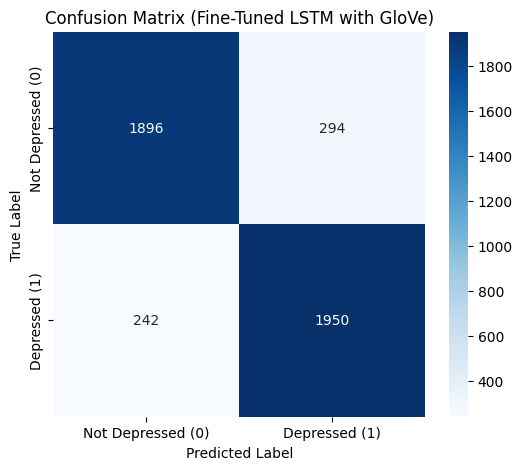



--- Time Complexity ---
Total Training Time: 1472.19 seconds (approx. 24.5 minutes)
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step
Total Inference Time for 4382 samples: 3.8997 seconds
Average Inference Time per Sample: 0.8899 milliseconds


--- Space Complexity ---
Total Model Parameters: 5,727,053
Model Size on Disk: 65.57 MB


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Performance Evaluation on Test Set ---
print("--- Final Performance Evaluation (Fine-Tuned LSTM with GloVe) ---")

# Get model's prediction probabilities on the test set
y_pred_probs = model.predict(X_test)

# Convert probabilities to binary class labels (0 or 1) using a 0.5 threshold
y_pred = (y_pred_probs > 0.5).astype("int32")

# Calculate and print the final metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_probs) # Use probabilities for ROC-AUC

print(f"\nOverall Test Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}\n")

# Display a detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Depressed (0)', 'Depressed (1)']))


# --- 2. Display the Confusion Matrix ---
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Depressed (0)', 'Depressed (1)'],
            yticklabels=['Not Depressed (0)', 'Depressed (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Fine-Tuned LSTM with GloVe)')
plt.show()
print("\n" + "="*50 + "\n")


# --- 3. Practical Time Complexity Analysis ---
print("--- Time Complexity ---")
print(f"Total Training Time: {training_time:.2f} seconds (approx. {training_time/60:.1f} minutes)")

# Measure Inference Time
inference_start_time = time.time()
_ = model.predict(X_test)
inference_end_time = time.time()
total_inference_time = inference_end_time - inference_start_time
avg_inference_time_per_sample = total_inference_time / len(X_test)

print(f"Total Inference Time for {len(X_test)} samples: {total_inference_time:.4f} seconds")
print(f"Average Inference Time per Sample: {avg_inference_time_per_sample * 1000:.4f} milliseconds\n")
print("="*50 + "\n")


# --- 4. Practical Space Complexity Analysis ---
print("--- Space Complexity ---")
total_params = model.count_params()
print(f"Total Model Parameters: {total_params:,}")

# Save the model with a unique name
model_filename = "depression_detection_LSTM_GloVe.keras"
model.save(model_filename)
model_size_bytes = os.path.getsize(model_filename)
model_size_mb = model_size_bytes / (1024 * 1024)

print(f"Model Size on Disk: {model_size_mb:.2f} MB")

In [ ]:
# ---  Print Model Summary ---
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 192, 100)       │     5,682,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,181,161 (65.54 MB)

 Trainable params: 5,727,053 (21.85 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,454,108 (43.69 MB)

In [ ]:
import os
import pickle

# --- 1. Save the Tokenizer to a file in the Colab environment ---
# This is essential for preprocessing new data with this model later on.
tokenizer_filename = 'tokenizer_fasttext.pickle'
with open(tokenizer_filename, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Keras Tokenizer saved to '{tokenizer_filename}'")


# --- 2. Copy the model artifacts to your Google Drive ---
# Define the destination folder in your Google Drive
destination_folder = '/content/drive/MyDrive/Depression detection dataset/saved_models/LSTM_GloVe_FineTuned/'

# Create the folder if it doesn't already exist
os.makedirs(destination_folder, exist_ok=True)

# List of all the files we want to save from this experiment
files_to_copy = [
    'depression_detection_LSTM_GloVe.keras', # Saved in the evaluation step
    'tokenizer_fasttext.pickle'                # Just saved now
]

# Loop through the files and copy them to your Drive
for filename in files_to_copy:
  source_path = f'./{filename}'
  destination_path = os.path.join(destination_folder, filename)
  if os.path.exists(source_path):
    !cp "{source_path}" "{destination_path}"
    print(f"Successfully copied '{filename}' to your Google Drive.")
  else:
    print(f"Warning: '{filename}' not found. Please ensure the previous cells were run.")

print(f"\nYour FastText model files are now safely stored in your Google Drive!")

Keras Tokenizer saved to 'tokenizer_fasttext.pickle'
Successfully copied 'depression_detection_LSTM_GloVe.keras' to your Google Drive.
Successfully copied 'tokenizer_fasttext.pickle' to your Google Drive.

Your FastText model files are now safely stored in your Google Drive!
